In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("../../src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

## Step 1:
### Init Network Topology and Electrostatic Properties:
- Network Topology either `"cubic"` or `"random"`
- `topology_parameter` defines network parameter via the following keys
- if `"cubic"`
    - `"Nx"`    :   Number of Nanoparticles in x-direction
    - `"Ny"`    :   Number of Nanoparticles in y-direction
    - `"Nz"`    :   Number of Nanoparticles in z-direction
    - `"e_pos"` :   Electrode positions as list of lists. Each element corresponds to nanoparticle position `[x,y,z]` which is attached to an electrode

- if `"random"`
    - `$N_{NP}$`    :   Number of Nanoparticles
    - `$N_{J}$`     :   Number of Junctions per Nanoparticle
    - `"e_pos"`     :   Electrode positions as list of lists. Each element corresponds to cartesian coordinates `[x,y]` of the specific electrode. Closest nanoparticle to this electrode will be attached to it

- `np_info` defines electrostatic properies via nanoparticle properties
    - `"eps_r"`         : relative permittivity of the insulating molecule
    - `"eps_s"`         : relative permittivity of the insulating SiO2 layer
    - `"mean_radius"`   : average nanoparticle radius [nm]
    - `"std_radius"`    : standard deviation nanopartcile radius [nm]  
    - `"np_distance"`   : spacing in between nanoparticles

In [2]:
# Example: Cubic Network
network_topology    = "cubic"

# Network Parameter
topology_parameter  = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[0,3,0],[6,0,0],[0,6,0],[6,3,0],[3,6,0],[6,6,0]]
}

# Nanoparticle Parameter
np_info = {
    "eps_r"         : 2.6,
    "eps_s"         : 3.9,
    "mean_radius"   : 10.0,
    "std_radius"    : 0.0,
    "np_distance"   : 1.0
}

# Nanoparticle Resistances
res_info = {
    "mean_R"    : 25.0,
    "std_R"     : 0.0    
}

# Save Folder
folder  = ""

# Network Class Object
np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter, folder=folder, np_info=np_info, res_info=res_info)

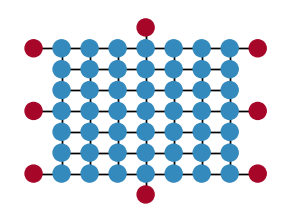

In [3]:
# Plot Network (blue : NP - red : Electrode)
fig, ax = nanonets_utils.display_network(np_network_sim=np_network_cubic, node_size=150)

In [4]:
# Example: Random Network
network_topology    = "random"

# Network Parameter
topology_parameter  = {
    "Np"    : 50,
    "Nj"    : 4,
    "e_pos" : [[-1,-1],[1,1]]
}

# Nanoparticle Parameter
np_info = {
    "eps_r"         : 2.6,
    "eps_s"         : 3.9,
    "mean_radius"   : 10.0,
    "std_radius"    : 0.0,
    "np_distance"   : 1.0
}

# Nanoparticle Resistances
res_info = {
    "mean_R"    : 25.0,
    "std_R"     : 0.0    
}

# Save Folder
folder  = ""

# Network Class Object
np_network_random = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter, folder=folder, np_info=np_info, res_info=res_info)

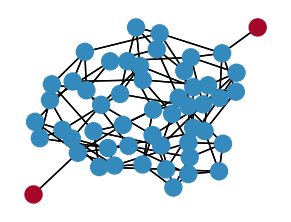

In [5]:
# Plot Network (blue : NP - red : Electrode)
fig, ax = nanonets_utils.display_network(np_network_sim=np_network_random, node_size=150)

## Step 2:
### Define Electrode Voltages
- Voltages are either constant in time or not
- In either case we need as many electrode voltages as there are electrodes connected to the network, otherwise --> Error
- Voltages are defined via an array
    - with columns corresponding to the electrode. First Column == First Electrode at position `topology_parameter['epos'][0]`
    - the last column corresponds to the gate electrode, which is electrostatic coupled to all nanopartciles, i.e. there **have to be** `N_electrodes + 1` in the voltage numpy array 
    - rows correspond either to the set of constant electrode voltages or to the voltage time series (first row = t0, second row = t1, ...)
    - most of the time there is an electrode referred as *output* which is generally grounded, i.e. $U = 0 V$
- In case of time dependent voltages one must also define a time scale as a simple 1D array

In [6]:
# Example: Constant Voltages
N_voltages      = 100
V_abs           = 0.1
voltages        = np.random.uniform(low=-V_abs, high=V_abs, size=(N_voltages, np_network_cubic.N_electrodes + 1))

# Last Electrode --> Grounded
voltages[:,-2]  = 0

print(voltages[:5,:])

[[ 0.07360134  0.00946219 -0.05282587  0.01345998  0.08031116  0.05925229
   0.0130999   0.         -0.0467042 ]
 [ 0.09718629 -0.07495287 -0.0315709   0.063986    0.02663871 -0.09035934
  -0.05871996  0.         -0.03703267]
 [ 0.01590355  0.06262074  0.02052293  0.02436059  0.08781649 -0.07224463
  -0.00768866  0.         -0.03196104]
 [-0.00495989 -0.08679227 -0.01203694  0.0174716  -0.08965097  0.08503687
  -0.00831564  0.         -0.05952307]
 [-0.06534125 -0.03119069  0.0839503   0.03771828 -0.08358163 -0.02524617
   0.0610145   0.         -0.03572741]]


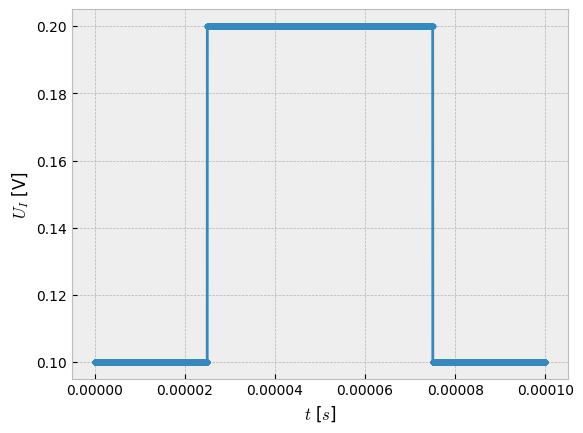

In [7]:
# Time Scale
step_size   = 1e-8
N_voltages  = 10000
time        = step_size*np.arange(N_voltages)

# Example: Time dependent Voltages
off_state   = 0.1
on_state    = 0.2
on_t1       = int(N_voltages/4)
on_t2       = int(3*N_voltages/4)
voltages    = np.zeros(shape=(N_voltages,3))

# Input Electrode
voltages[:,0]           = np.repeat(off_state, N_voltages)
voltages[on_t1:on_t2]   = on_state

with plt.style.context("bmh"):
    
    plt.plot(time, voltages[:,0], '.-')
    plt.xlabel("$t$ [$s$]")
    plt.ylabel("$U_I$ [V]")
    plt.show()

## Step 3:
### Run Simulation
- For const voltages `run_const_voltages()` and time dependent voltages `run_var_voltages()`
- `run_const_voltages()` arguments:
    - voltages  :   s.o
    - target_electrode  :   output electrode

In [ ]:
np_network_cubic.run_const_voltages(voltages=voltages, target_electrode=)
np_network_random.run_var_voltages

In [7]:
def run_simulation(voltages, time_steps, target_electrode, network_topology, topology_parameter, R, Rstd, store_per_it_min, store_per_it_max, folder="", n_stat=10, save_th=.1, start_val=100):

    output_vals     = []
    microstate      = []
    landscape       = []
    net_currents    = []
    network_classes = []
    
    for _ in range(n_stat):
    
        np_network_sim = nanonets.simulation(network_topology=network_topology, folder=folder, topology_parameter=topology_parameter)
        np_network_sim.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=target_electrode, save_th=save_th,
                                        store_per_it_min=store_per_it_min, store_per_it_max=store_per_it_max, R=R, Rstd=Rstd)
        
        # Return Output Current
        output_df               = pd.DataFrame(np_network_sim.return_output_values()).iloc[start_val:,1:3].reset_index(drop=True)
        output_df.columns       = ["Jumps","Current"]
        output_df["Current"]    = output_df["Current"]/1000

        # Return Microstate
        microstate_df   = pd.DataFrame(np_network_sim.return_microstates()).iloc[start_val:,:].reset_index(drop=True)

        # Return Landscape
        landscape_df    = pd.DataFrame(np_network_sim.return_potential_landscape()).iloc[start_val:,np_network_sim.N_electrodes:].reset_index(drop=True)

        # Return Network Currents
        jump_paths, network_I   = np_network_sim.return_network_currents()
        network_I_df            = pd.DataFrame(network_I)
        network_I_df.columns    = jump_paths
        network_I_df            = network_I_df.iloc[start_val:].reset_index(drop=True)

        # Append Results
        output_vals.append(output_df)
        microstate.append(microstate_df)
        landscape.append(landscape_df)
        net_currents.append(network_I_df)
        network_classes.append(np_network_sim)

    outputs = {
        "output"            : output_vals,
        "microstate"        : microstate,
        "landscape"         : landscape,
        "net_currents"      : net_currents,
        "network_classes"   : network_classes
    }

    return outputs

In [8]:
store_per_it_min    = 12e-6
store_per_it_max    = 14e-6
simulation_outputs  = run_simulation(voltages=voltages, time_steps=time_steps, target_electrode=N_electrodes-1,
                    network_topology=network_topology, topology_parameter=topology_parameter,
                    R=25.0, Rstd=5.0, store_per_it_min=store_per_it_min, store_per_it_max=store_per_it_max, start_val=start_val)

KeyboardInterrupt: 

In [ ]:
output_values               = pd.concat([pd.DataFrame(np.mean(simulation_outputs['output'],axis=0)),pd.DataFrame(np.std(simulation_outputs['output'],axis=0))/np.sqrt(len(simulation_outputs['output']))],axis=1)
output_values.columns       = ["Jumps","Current","Jumps_Error","Current_Error"] 
microstate                  = pd.DataFrame(np.mean(simulation_outputs["microstate"],axis=0))
microstate_error            = pd.DataFrame(np.std(simulation_outputs["microstate"],axis=0))/np.sqrt(len(simulation_outputs["microstate"]))
landscape                   = 1000*pd.DataFrame(np.mean(simulation_outputs["landscape"],axis=0))
landscape_error             = 1000*pd.DataFrame(np.std(simulation_outputs["landscape"],axis=0))/np.sqrt(len(simulation_outputs["landscape"]))
net_currents                = pd.DataFrame(np.mean(simulation_outputs["net_currents"],axis=0))
net_currents.columns        = simulation_outputs["net_currents"][0].columns
net_currents_error          = pd.DataFrame(np.std(simulation_outputs["net_currents"],axis=0))/np.sqrt(len(simulation_outputs["net_currents"]))
net_currents_error.columns  = simulation_outputs["net_currents"][0].columns

In [ ]:
print(f"Average Jumps per Step: {np.round(output_values['Jumps'].mean(),2)}")

Average Jumps per Step: 38.21


### Output electric Current

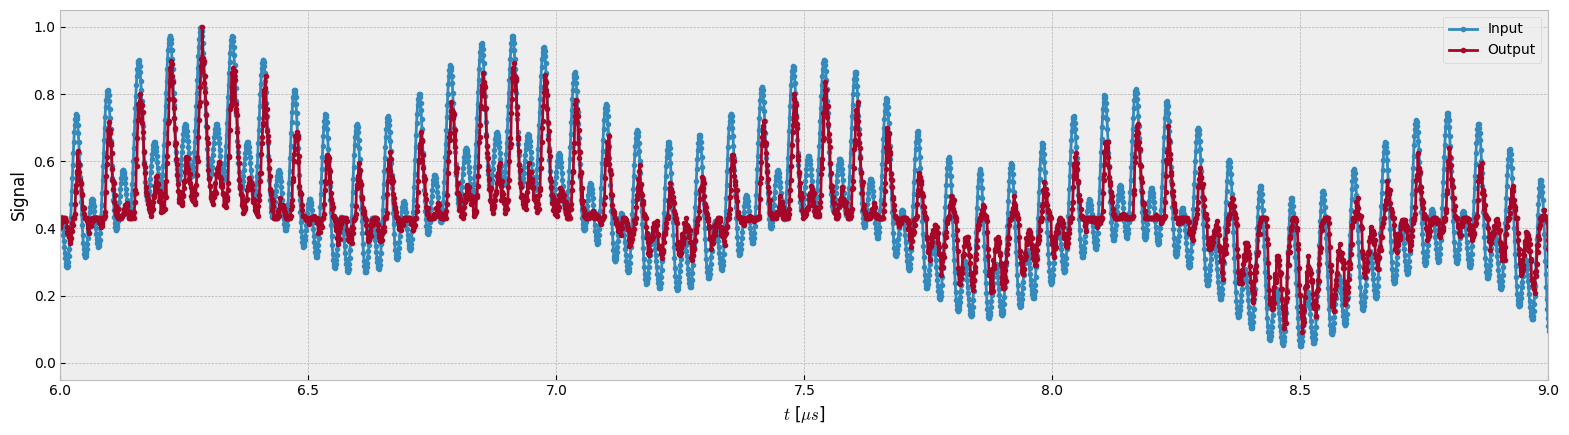

In [ ]:
normed_input    = (inputs - np.min(inputs))/(np.max(inputs)-np.min(inputs))
normed_output   = (output_values['Current'] - np.min(output_values['Current']))/(np.max(output_values['Current'])-np.min(output_values['Current']))

with plt.style.context("bmh"):

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth()*3)
    fig.set_figheight(fig.get_figheight())
    ax  = fig.add_subplot()
    ax.plot(time, normed_input, '.-', label="Input")
    ax.plot(time, normed_output, '.-', label="Output")
    # ax.fill_between(x=time, y1=(output_values['Current']-output_values['Current_Error']), y2=(output_values['Current']+output_values['Current_Error']), alpha=0.8)
    # ax.plot(time, inputs, '.-', label="Input")
    ax.set_xlabel("$t$ [$\mu s$]")
    ax.set_ylabel("Signal")
    ax.legend()
    ax.set_xlim(6,9)
    
plt.show()

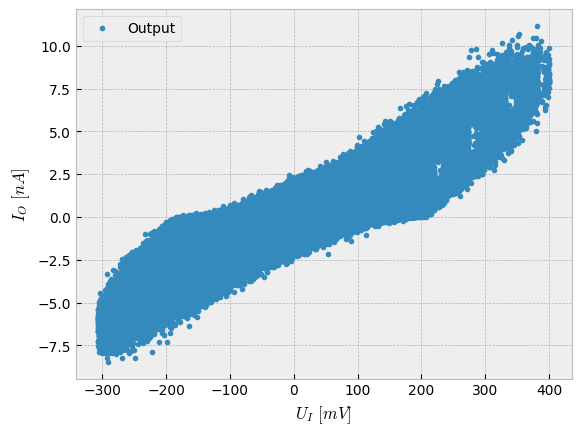

In [ ]:
with plt.style.context("bmh"):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(inputs, output_values['Current'], '.', label="Output")
    # ax.plot(time, inputs, '.-', label="Input")
    ax.set_xlabel("$U_{I}$ $[mV]$")
    ax.set_ylabel("$I_O$ $[nA]$")
    ax.legend()


In [ ]:
plt.rcParams["animation.html"] = "jshtml"
from IPython.display import HTML

In [ ]:
output_values['Current']

0        2.214626
1        1.662930
2        1.327985
3        0.851101
4        1.092451
           ...   
99894    1.242040
99895    1.222593
99896    1.115048
99897    1.222163
99898    1.547790
Name: Current, Length: 99899, dtype: float64

MovieWriter ffmpeg unavailable; using Pillow instead.


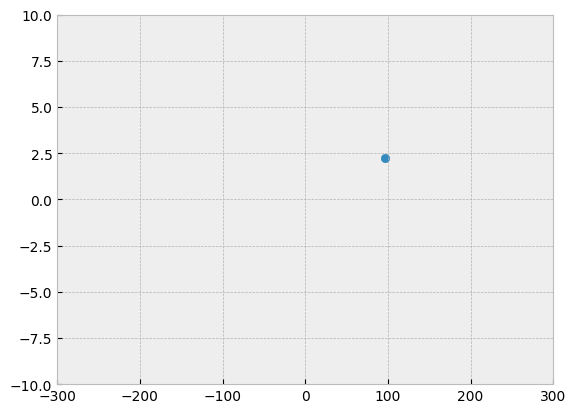

In [ ]:
with plt.style.context("bmh"):

    fig, ax = plt.subplots()
    ax.set_xlim(-300,300)
    ax.set_ylim(-10,10)

    scat = ax.scatter(inputs[0],output_values['Current'][0])

    def animate(i):
        scat.set_offsets((inputs[i],output_values['Current'][i]))
        return scat,

    ani = animation.FuncAnimation(fig, animate, repeat=True,
                                        frames=1000, interval=1)

ani.save("test.gif")

#### Micro State

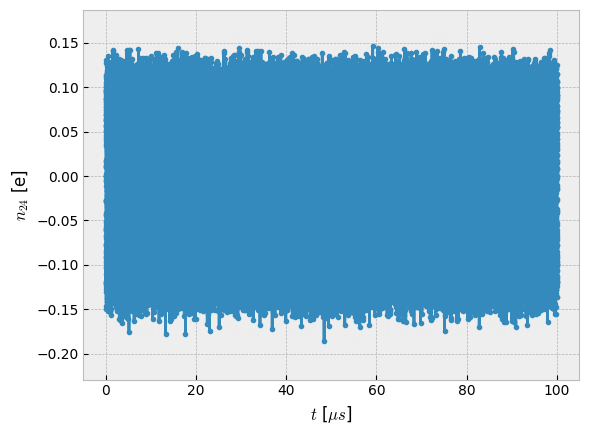

In [ ]:
np_index = 24

with plt.style.context("bmh"):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(time, microstate[np_index], '.-')
    ax.fill_between(x=time, y1=(microstate[np_index]-microstate_error[np_index]), y2=(microstate[np_index]+microstate_error[np_index]), alpha=0.8)
    ax.set_xlabel("$t$ [$\mu s$]")
    ax.set_ylabel("$n_{"+f"{np_index}"+"}$ [e]")
    # ax.set_xscale('log')
    plt.show()

#### NP Potential

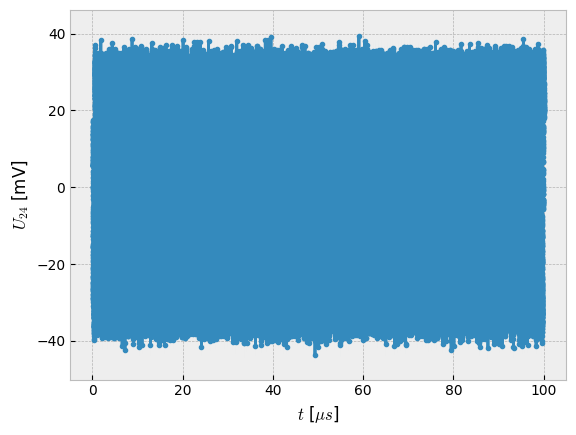

In [ ]:
np_index = 24

with plt.style.context("bmh"):

    fig = plt.figure()
    ax  = fig.add_subplot()
    ax.plot(time, landscape[np_index], '.-')
    ax.fill_between(x=time, y1=(landscape[np_index]-landscape_error[np_index]), y2=(landscape[np_index]+landscape_error[np_index]), alpha=0.8)
    ax.set_xlabel("$t$ [$\mu s$]")
    ax.set_ylabel("$U_{"+f"{np_index}"+"}$ [mV]")
    # ax.set_xscale('log')
    plt.show()

### Potential and Jumps Evolution

In [ ]:
def return_auto_corr(time, arr, n_lags=20):

    time    = time - np.min(time)
    time    = time[:n_lags]
    a_c     = [1. if t==0 else np.corrcoef(arr[:-t],arr[t:])[0,1] for t in range(n_lags)]

    return time, a_c

def collect_auto_corr(time_evo, arr, t_range, n_stats=50, n_lags=20):

    corr    = pd.DataFrame()

    for i in range(n_stats):

        try:
            t, a_c  = return_auto_corr(time_evo[i], arr[i], n_lags=n_lags)
            func    = interp1d(t, a_c)

            corr[i] = func(t_range)
        except:
            pass
    
    return corr

In [ ]:
np_index        = 24
n_run           = 0
stored_indices  = np.where((time_steps >= store_per_it_min) & (time_steps < store_per_it_max))[0]
potential_evo   = [simulation_outputs["network_classes"][n_run].return_pot_per_it()[i][1:,np_index] for i in stored_indices]
time_evo        = [simulation_outputs["network_classes"][n_run].return_time_vals()[i][1:]*10**9 for i in stored_indices]

In [ ]:
def jump_diff(np_index, connected_nps):

    abgänge = []

    for i_np in connected_nps:

        jump_index      = np.where(net_currents.columns == (np_index,i_np))[0][0]
        jumps_evo       = [simulation_outputs["network_classes"][n_run].return_jumps_per_it()[i][1:,jump_index] for i in stored_indices]
        jumps_evo       = [np.insert((jumps_evo[i][1:] - jumps_evo[i][0:-1]),0,0) for i in range(len(stored_indices))]
        abgänge.append(jumps_evo)

    zugänge = []

    for i_np in connected_nps:

        jump_index      = np.where(net_currents.columns == (i_np,np_index))[0][0]
        jumps_evo       = [simulation_outputs["network_classes"][n_run].return_jumps_per_it()[i][1:,jump_index] for i in stored_indices]
        jumps_evo       = [np.insert((jumps_evo[i][1:] - jumps_evo[i][0:-1]),0,0) for i in range(len(stored_indices))]
        zugänge.append(jumps_evo)
    
    return np.sum(zugänge,axis=0) - np.sum(abgänge,axis=0)

jump_zu_ab = jump_diff(26, [1,21,25])

/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
t_range_pot     = np.linspace(0,0.15,100)
t_range_jump    = np.linspace(0,0.15,100)
pot_auto_corr   = collect_auto_corr(time_evo, potential_evo, t_range_pot)
jump_auto_corr  = collect_auto_corr(time_evo, jump_zu_ab, t_range_jump)

/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/jonasmensing/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None

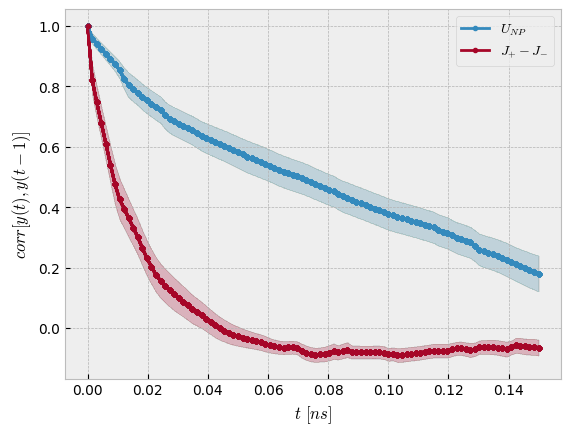

In [ ]:
y_pot   = pot_auto_corr.mean(axis=1)
y_jump  = jump_auto_corr.mean(axis=1)

y1_pot  = y_pot - pot_auto_corr.std(axis=1)/np.sqrt(len(pot_auto_corr.columns))
y2_pot  = y_pot + pot_auto_corr.std(axis=1)/np.sqrt(len(pot_auto_corr.columns))

y1_jump = y_jump - jump_auto_corr.std(axis=1)/np.sqrt(len(jump_auto_corr.columns))
y2_jump = y_jump + jump_auto_corr.std(axis=1)/np.sqrt(len(jump_auto_corr.columns))

with plt.style.context("bmh"):
    
    fig = plt.figure()
    ax  = fig.add_subplot()

    for i in range(20):

        ax.plot(t_range_pot, y_pot, '.-', c=blue_color, label='$U_{NP}$')
        ax.fill_between(t_range_pot, y1_pot, y2_pot, color=blue_color, alpha=0.01)

        ax.plot(t_range_jump, y_jump, '.-', c=red_color, label='$J_{+}-J_{-}$')
        ax.fill_between(t_range_jump, y1_jump, y2_jump, color=red_color, alpha=0.01)

        if i == 0:
            ax.legend()

    ax.set_ylabel("$corr[y(t),y(t-1)]$")
    ax.set_xlabel("$t$ $[ns]$")

plt.show()